In [1]:
from core.TrajectoryDF import NumPandasTraj as TrajDF
from features.spatial_features import SpatialFeatures as spatial
from features.temporal_features import TemporalFeatures as temporal
import matplotlib.pyplot as plt
from preprocessing.interpolation import Interpolation as ip
from preprocessing.filters import Filters as filt
from utilities.conversions import Conversions as con
from preprocessing.helpers import Helpers as help

import utilities.constants as const
import pandas as pd
from scipy.interpolate import CubicSpline, interp2d
import numpy as np

In [2]:
%%time

atlantic = pd.read_csv('./data/atlantic.csv')
atlantic = con.convert_directions_to_degree_lat_lon(atlantic, 'Latitude',"Longitude")
def convert_to_datetime(row):
        this_date = '{}-{}-{}'.format(str(row['Date'])[0:4], str(row['Date'])[4:6], str(row['Date'])[6:])
        this_time = '{:02d}:{:02d}:00'.format(int(row['Time']/100), int(str(row['Time'])[-2:]))
        return '{} {}'.format(this_date, this_time)
atlantic['DateTime'] = atlantic.apply(convert_to_datetime, axis=1)
sample = TrajDF(atlantic,
                latitude='Latitude',
                longitude='Longitude',
                datetime='DateTime',
                traj_id='ID',
                rest_of_columns=[])
# gulls = pd.read_csv('./data/gulls.csv')
# sample = TrajDF(gulls,
#                 latitude='location-lat',
#                 longitude='location-long',
#                 datetime='timestamp',
#                 traj_id='tag-local-identifier',
#                 rest_of_columns=[])
# rf = pd.read_csv('./data/geolife_sample.csv')
# sample = TrajDF(rf, 'lat', 'lon', 'datetime', 'id')

CPU times: user 7.9 s, sys: 71.9 ms, total: 7.97 s
Wall time: 7.98 s


In [3]:
small = sample.reset_index().loc[sample.reset_index()[const.TRAJECTORY_ID] == 'AL072010'][[const.TRAJECTORY_ID, const.DateTime, const.LAT, const.LONG]]
a = small.reset_index()[const.DateTime].diff().dt.total_seconds()
print((a > 3600*4).value_counts())


True     51
False     4
Name: DateTime, dtype: int64


In [4]:
%%time

small_ip_rw = help._random_walk_help(small.reset_index(drop=True).set_index([const.DateTime]), 'AL072010', 3600*4)
print(f"Original Length: {len(small)}")
print(f"Interpolated Length: {len(small_ip_rw)}")

Original Length: 55
Interpolated Length: 106
CPU times: user 229 ms, sys: 398 µs, total: 230 ms
Wall time: 224 ms


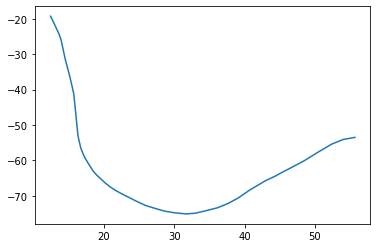

In [5]:
plt.plot(small[const.LAT], small[const.LONG])


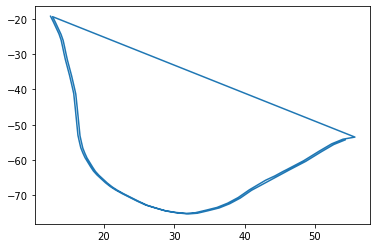

In [6]:
plt.plot(small_ip_rw[const.LAT], small_ip_rw[const.LONG])


In [7]:
%%time

ip_rw = ip.interpolate_position(sample,
                                3600*4,
                                'random-walk')
print(f"Original Length: {len(sample)}")
print(f"Interpolated Length: {len(ip_rw)}")

Process Process-20:
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/yjharanwala/anaconda3/envs/PreprocessingLibrary/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/yjharanwala/anaconda3/envs/PreprocessingLibrary/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/yjharanwala/Desktop/NumMobility/preprocessing/helpers.py", line 212, in _random_walk_help
    calc_a = d_mean.rvs()
  File "/home/yjharanwala/anaconda3/envs/PreprocessingLibrary/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 456, in rvs
    return self.dist.rvs(*self.args, **kwds)
  File "/home/yjharanwala/anaconda3/envs/PreprocessingLibrary/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py", line 979, in rvs
    raise ValueError("Domain error in arguments.")
ValueError: Domain error in arguments.
"""

Original Length: 49105
Interpolated Length: 89792
CPU times: user 237 ms, sys: 192 ms, total: 430 ms
Wall time: 37.4 s


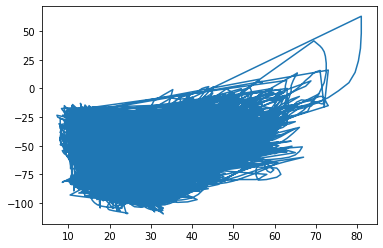

In [8]:
plt.plot(sample[const.LAT], sample[const.LONG])

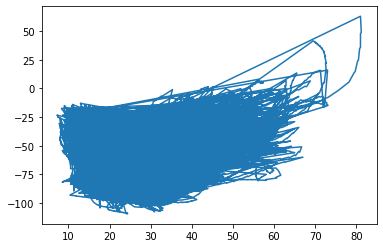

In [9]:
plt.plot(ip_rw[const.LAT], ip_rw[const.LONG])

In [10]:
b = sample.reset_index()[const.DateTime].diff().dt.total_seconds()
print((b > 3600*4).value_counts())

True     47785
False     1320
Name: DateTime, dtype: int64
